# 02. Neural Network Classification with PyTorch

## TK - What we're going to cover

TODO
* Simple classification (reiterate PyTorch workflow)
    * Binary classification
    * Multi-class classification
* Writing device agnostic code
    * Data on GPU
    * Model on GPU
* More advanced classification (e.g. black and white images or FashionMNIST or FoodMNIST or something)
* Visualizing a PyTorch model (all of the different connections)


## TK - How you can use this notebook

## TK - Architecture of a classification network

## TK - Make data

In [1]:
from sklearn.datasets import make_moons

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_moons(n_samples,
                  noise=0.07,
                  random_state=42) # keep random state so we get the same values

In [2]:
# Get dataframe of moons
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head()

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


In [3]:
# Check different labels
moons.label.value_counts()

1    500
0    500
Name: label, dtype: int64

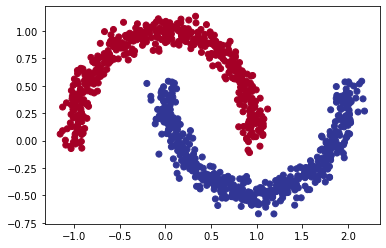

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, plt.cm.RdYlBu)

TK - why show data like this? This is a toy problem but it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify (separate red from blue) it.

## TK - Input and output shapes

In [5]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# Check how many samples we have
len(X), len(y)

(1000, 1000)

In [7]:
# View the first example of features and labels
X[0], y[0]

(array([-0.03341062,  0.4213911 ]), 1)

In [9]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X, y

(tensor([[-0.0334,  0.4214],
         [ 0.9988, -0.4429],
         [ 0.8896, -0.3278],
         ...,
         [ 1.6713, -0.3240],
         [-0.9530,  0.3022],
         [ 0.7916,  0.6113]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
         0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,


## TK - Steps in modelling

1. Construct the model
2. Setup loss and optimizer
3. Create training/eval loop

### TK - Building a model 

In [38]:
from torch import nn
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # TK - explain in and out features (could use TF playground for this)
        self.layer_2 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = MoonModelV0()
model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)

In [48]:
# TODO, show case the same model with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)

### TK - Setup loss and optimizer

In [49]:
# TK - Explain both of these - https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = Sigmoid built-in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [50]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### TK - Train model

In [51]:
# TK - clean this up for different data types (could be far clearer what's going on)
torch.manual_seed(42)
epochs = 100
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_0(X).squeeze() # this won't work unless X & y are tensors
    # print(y_pred)
    # print(torch.round(torch.sigmoid(y_pred)))
    
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_pred), y) # Using nn.BCELoss you need torch.sigmoid()
    loss = loss_fn(y_pred, y) # using nn.BCEWithLogitsLoss you *don't* need torch.sigmoid()
    acc = accuracy_fn(y_true=y, 
                      y_pred=torch.round(torch.sigmoid(y_pred)))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}")

Epoch: 0 | Loss: 0.786084771156311, Accuracy: 50.0
Epoch: 10 | Loss: 0.6237784624099731, Accuracy: 74.4
Epoch: 20 | Loss: 0.5625039935112, Accuracy: 78.4
Epoch: 30 | Loss: 0.5106662511825562, Accuracy: 78.9
Epoch: 40 | Loss: 0.4626114070415497, Accuracy: 80.60000000000001
Epoch: 50 | Loss: 0.42042669653892517, Accuracy: 81.10000000000001
Epoch: 60 | Loss: 0.38570988178253174, Accuracy: 82.39999999999999
Epoch: 70 | Loss: 0.35836920142173767, Accuracy: 83.3
Epoch: 80 | Loss: 0.33723264932632446, Accuracy: 83.89999999999999
Epoch: 90 | Loss: 0.3208741545677185, Accuracy: 84.39999999999999


## TK - Plot model predictions

In [ ]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [52]:
import numpy as np
def plot_multiclass_decision_boundary(model, X, y):
    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = torch.round(torch.sigmoid(model(X_test)))
    # _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

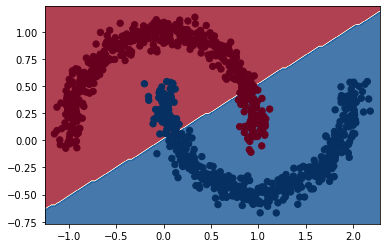

In [53]:
plot_multiclass_decision_boundary(model_0, X, y)

## TK - Improving a model

TODO
* Add layers 
* Add units
* Train for longer...


In [56]:
class MoonModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # always make sure forward is spelt correctly!
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = MoonModelV1()
model_1

MoonModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [57]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [58]:
epochs = 1000
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_1(X).squeeze()

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_true=y, 
                      y_pred=torch.round(torch.sigmoid(y_pred)))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print outputs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}")


Epoch: 0 | Loss: 0.7222902774810791, Accuracy: 26.5
Epoch: 100 | Loss: 0.2570977509021759, Accuracy: 87.4
Epoch: 200 | Loss: 0.24484682083129883, Accuracy: 88.6
Epoch: 300 | Loss: 0.2445026934146881, Accuracy: 88.6
Epoch: 400 | Loss: 0.24449196457862854, Accuracy: 88.6
Epoch: 500 | Loss: 0.24449162185192108, Accuracy: 88.6
Epoch: 600 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 700 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 800 | Loss: 0.2444916069507599, Accuracy: 88.6
Epoch: 900 | Loss: 0.2444916069507599, Accuracy: 88.6


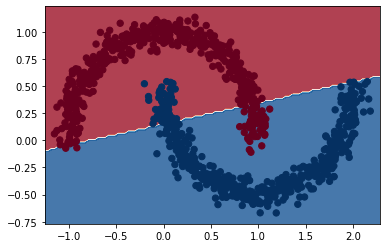

In [60]:
plot_multiclass_decision_boundary(model_1, X, y)

Pretty good... but still not where we'd like it.

Our model is drawing straight lines... but we'd like the lines to be curved, what can we do? 

How about we check our model on linear data, what does that do?

In [91]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

# TK - change these variable names so they don't interfere with the original moons data

# Create data
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [92]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [109]:
# TK - put this in helper function file... 
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

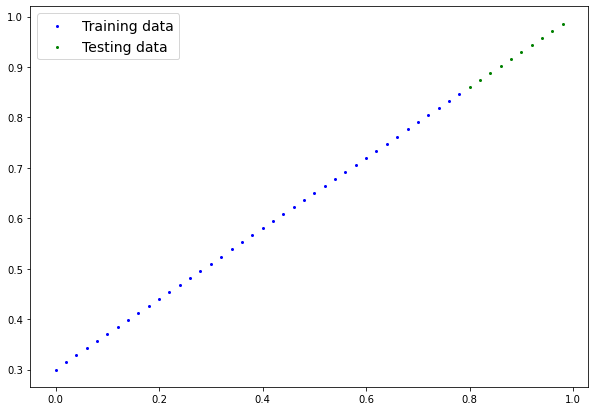

In [110]:
plot_predictions();

In [111]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [112]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [113]:
# Train the model
epochs = 1000
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_2(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss}, Test loss: {test_loss}")


Epoch: 0 | Train loss: 0.3499740958213806, Test loss: 0.3346957862377167
Epoch: 100 | Train loss: 0.10616479068994522, Test loss: 0.014528954401612282
Epoch: 200 | Train loss: 0.08514316380023956, Test loss: 0.021083522588014603
Epoch: 300 | Train loss: 0.07476572692394257, Test loss: 0.03018217161297798
Epoch: 400 | Train loss: 0.06505356729030609, Test loss: 0.010706442408263683
Epoch: 500 | Train loss: 0.062374867498874664, Test loss: 0.02989591285586357
Epoch: 600 | Train loss: 0.05085625499486923, Test loss: 0.009743076749145985
Epoch: 700 | Train loss: 0.04616856575012207, Test loss: 0.01373409666121006
Epoch: 800 | Train loss: 0.06383290141820908, Test loss: 0.02982897125184536
Epoch: 900 | Train loss: 0.05753083899617195, Test loss: 0.016358565539121628


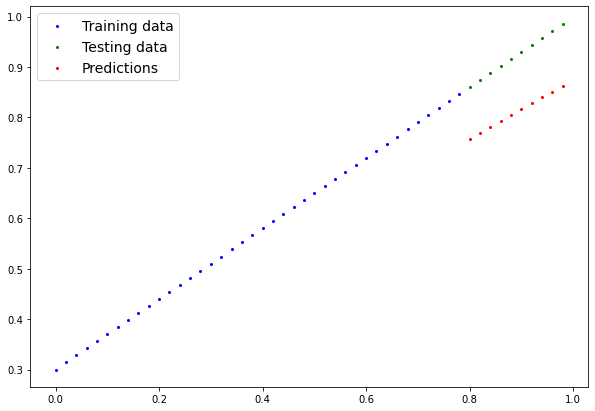

In [115]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test)
plot_predictions(predictions=y_preds.detach().numpy());

## TK - The missing piece: non-linearity

Our model can draw straight lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

Let's try.

In [123]:
# Make data
from sklearn.datasets import make_moons

n_samples = 1000

X, y = make_moons(n_samples=1000,
    noise=0.15,
    random_state=42,
)

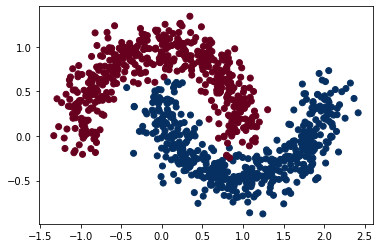

In [124]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [125]:
# Convert to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:10], y[:10]

(tensor([[-0.0816,  0.4822],
         [ 1.0873, -0.3812],
         [ 0.8317, -0.1331],
         [ 0.2003, -0.5003],
         [-0.8250,  0.5395],
         [ 0.6381, -0.1634],
         [ 0.2805, -0.1956],
         [-0.0858,  0.5065],
         [ 1.5883, -0.3195],
         [ 0.7368,  0.9106]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [127]:
# Build model
class MoonModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = MoonModelV2()
model_3

MoonModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [129]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [130]:
# Fit the model
epochs = 1000
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_3(X).squeeze()
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y_true=y, 
                      y_pred=torch.round(torch.sigmoid(y_pred)))
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}")

Epoch: 0 | Loss: 0.6949514150619507, Accuracy: 50.0
Epoch: 100 | Loss: 0.3169858753681183, Accuracy: 85.3
Epoch: 200 | Loss: 0.26603350043296814, Accuracy: 87.2
Epoch: 300 | Loss: 0.2549421787261963, Accuracy: 88.5
Epoch: 400 | Loss: 0.24335025250911713, Accuracy: 89.5
Epoch: 500 | Loss: 0.22968962788581848, Accuracy: 90.2
Epoch: 600 | Loss: 0.2121753692626953, Accuracy: 90.9
Epoch: 700 | Loss: 0.18871915340423584, Accuracy: 91.7
Epoch: 800 | Loss: 0.16001953184604645, Accuracy: 93.5
Epoch: 900 | Loss: 0.12989026308059692, Accuracy: 94.89999999999999


In [141]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

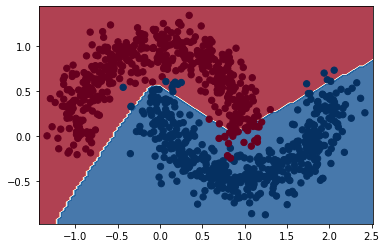

In [142]:
plot_multiclass_decision_boundary(model_3, X, y)

## Multi-class model 

In [169]:
from sklearn.datasets import make_blobs

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=2,
    centers=4,
    random_state=42
)

# Turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob[:10], y_blob[:10]

(tensor([[-8.5550,  7.0646],
         [-6.1375, -6.5808],
         [-6.3213, -6.8041],
         [ 4.1805,  1.1233],
         [ 4.3803,  0.4700],
         [-6.8226, -6.6115],
         [ 5.0201,  2.5838],
         [-5.9633, -6.5336],
         [-6.6557, -5.5160],
         [ 5.8464,  1.1562]]),
 tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]))

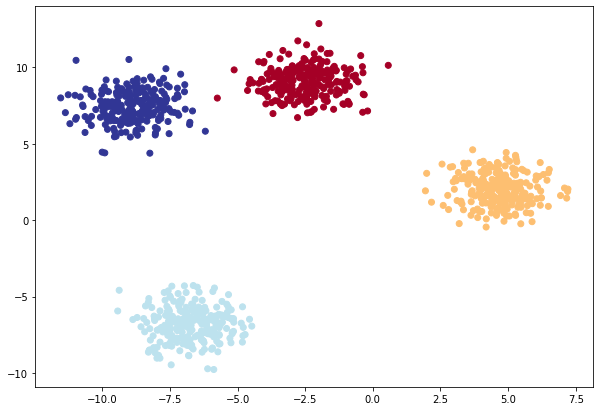

In [202]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [185]:
# Build model
class BlobModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=4), # how many classes are there?
            # nn.Softmax(dim=0)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel()
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [186]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [187]:
# Fit the model
epochs = 100
for epoch in range(epochs):
    # 1. Forward pass
    y_pred = model_4(X_blob)
    # print(y_pred)
    # print(y_pred.argmax(dim=1))
    # print(y.dtype)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_pred, y_blob)
    acc = accuracy_fn(y_true=y_blob,
                      y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}")

Epoch: 0 | Loss: 1.7489259243011475, Accuracy: 50.6
Epoch: 10 | Loss: 0.478372722864151, Accuracy: 98.4
Epoch: 20 | Loss: 0.09058795124292374, Accuracy: 99.9
Epoch: 30 | Loss: 0.04101148620247841, Accuracy: 99.9
Epoch: 40 | Loss: 0.02593114972114563, Accuracy: 99.9
Epoch: 50 | Loss: 0.01895323023200035, Accuracy: 99.9
Epoch: 60 | Loss: 0.014972763136029243, Accuracy: 99.9
Epoch: 70 | Loss: 0.012410271912813187, Accuracy: 99.9
Epoch: 80 | Loss: 0.010628702118992805, Accuracy: 99.9
Epoch: 90 | Loss: 0.009321735240519047, Accuracy: 99.9


In [196]:
model_4.eval()
with torch.inference_mode():
    y_preds = model_4(X_blob)
torch.softmax(y_preds, dim=1).argmax(dim=1)[:10], y_preds.argmax(dim=1)[:10]

(tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]),
 tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]))

In [207]:
# UPTOHERE - make this work with blobs 
def plot_multiclass_decision_boundary(model, X, y):
    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    ### This line will deal with multi-class/binary class
    y_pred = torch.softmax(model(X_test), dim=1).argmax(dim=1)
    # _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

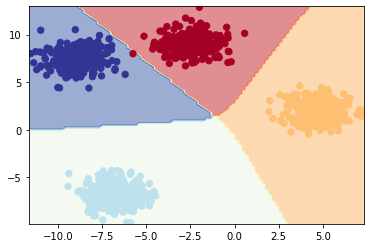

In [208]:
plot_multiclass_decision_boundary(model_4, X_blob, y_blob)

### Data

PyTorch FashionMNIST - https://pytorch.org/vision/stable/datasets.html

### Model

TODO
* Make multi-class model
* Visualize the model

### Evaluate

## TODO
* Multiclass model
* device agnostic code: GPU model 
* Fixed data inputs (e.g. calc on tensors when need to calc on tensors)
* Merge the functions so `plot_decision_boundary` works on multi-class
* Introduce non-linearity (the missing piece!) - straight lines and non-straight lines
* Make plotting function work with multi-classes